In [2]:
import numpy as np
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from renormalization_np import track_rg_flow

def analyze_coefficients_vs_J_parallel(J_values, M=0.0, n_max=20, n_steps=50, b=2, d=2, n_workers=None):
    """
    Parallelized version of analyze_coefficients_vs_J using joblib for better
    compatibility with Jupyter notebooks.
    
    Args:
        J_values: Array of J values to analyze
        M: Fixed M value to use (default 0.0 to look for fixed-line behavior)
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        n_workers: Number of workers for parallelization (default: None = auto)
    
    Returns:
        Dictionary with coefficient data
    """
    def process_single_J(J):
        """Process a single J value"""
        # Track the RG flow
        flow_history = track_rg_flow(J, J, M, b, d, n_max, n_steps)
        
        # Extract final coefficients
        final_coeffs = flow_history[-1]
        
        # Store key coefficients (real parts)
        coeffs = np.zeros(7)
        coeffs[0] = final_coeffs[n_max, n_max].real       # (0,0)
        coeffs[1] = final_coeffs[n_max+1, n_max].real     # (1,0)
        coeffs[2] = final_coeffs[n_max, n_max+1].real     # (0,1)
        coeffs[3] = final_coeffs[n_max+1, n_max+1].real   # (1,1)
        coeffs[4] = final_coeffs[n_max+2, n_max].real     # (2,0)
        coeffs[5] = final_coeffs[n_max, n_max+2].real     # (0,2)
        coeffs[6] = final_coeffs[n_max+2, n_max+2].real   # (2,2)
        
        # Calculate key ratios
        ratios = np.zeros(6)
        if abs(coeffs[0]) > 1e-10:
            ratios[0] = coeffs[1] / coeffs[0]  # (1,0)/(0,0)
            ratios[1] = coeffs[2] / coeffs[0]  # (0,1)/(0,0)
            ratios[2] = coeffs[3] / coeffs[0]  # (1,1)/(0,0)
            ratios[3] = coeffs[4] / coeffs[0]  # (2,0)/(0,0)
            ratios[4] = coeffs[5] / coeffs[0]  # (0,2)/(0,0)
            ratios[5] = coeffs[6] / coeffs[0]  # (2,2)/(0,0)
        
        # Calculate deviation from Villain form
        villain_deviation = np.nan
        if abs(coeffs[1]) > 1e-10 and abs(coeffs[4]) > 1e-10:
            ratio_10_20 = coeffs[4] / coeffs[1]  # (2,0)/(1,0)
            
            if ratio_10_20 > 0:
                Jv = -3 / (2 * np.log(ratio_10_20))
                
                # Calculate expected values for Villain model
                expected_values = np.zeros(7)
                
                # Calculate normalization for Villain model
                norm = 0
                for n in range(-min(10, n_max), min(10, n_max)+1):
                    for m in range(-min(10, n_max), min(10, n_max)+1):
                        norm += np.exp(-(n**2 + m**2)/(2*Jv))
                
                # Calculate expected values
                expected_values[0] = 1.0  # (0,0) normalized
                expected_values[1] = np.exp(-1/(2*Jv))  # (1,0)
                expected_values[2] = np.exp(-1/(2*Jv))  # (0,1)
                expected_values[3] = np.exp(-2/(2*Jv))  # (1,1)
                expected_values[4] = np.exp(-4/(2*Jv))  # (2,0)
                expected_values[5] = np.exp(-4/(2*Jv))  # (0,2)
                expected_values[6] = np.exp(-8/(2*Jv))  # (2,2)
                
                # Calculate deviation
                deviation = 0
                for j in range(7):
                    if abs(coeffs[0]) > 1e-10:
                        norm_coeff = coeffs[j] / coeffs[0]
                        norm_expected = expected_values[j] / expected_values[0]
                        deviation += (norm_coeff - norm_expected)**2
                
                villain_deviation = np.sqrt(deviation)
        
        return coeffs, ratios, villain_deviation
    
    # Initialize arrays
    n_coeffs = 7  # Updated for all 7 coefficients
    coefficients = np.zeros((len(J_values), n_coeffs))
    ratios = np.zeros((len(J_values), 6))  # Updated for 6 ratios
    villain_deviation = np.zeros(len(J_values))
    
    # Set up the number of workers (physical cores)
    if n_workers is None:
        try:
            import psutil
            n_workers = psutil.cpu_count(logical=False)
            if n_workers is None:
                n_workers = max(1, (psutil.cpu_count() or 4) // 2)
        except ImportError:
            import multiprocessing as mp
            n_workers = max(1, mp.cpu_count() // 2)
    
    # Process J values in parallel with joblib
    print(f"Processing {len(J_values)} J values using {n_workers} workers...")
    start_time = time.time()
    
    results = Parallel(n_jobs=n_workers, verbose=10)(
        delayed(process_single_J)(J) for J in J_values
    )
    
    elapsed = time.time() - start_time
    print(f"Processing complete! Elapsed time: {elapsed:.1f}s")
    
    # Unpack results
    for i, (coeffs, rats, vd) in enumerate(results):
        coefficients[i] = coeffs
        ratios[i] = rats
        villain_deviation[i] = vd
    
    # Return results dictionary
    return {
        'J_values': J_values,
        'M': M,
        'coefficients': coefficients,
        'ratios': ratios,
        'villain_deviation': villain_deviation,
        'coeff_labels': ['(0,0)', '(1,0)', '(0,1)', '(1,1)', '(2,0)', '(0,2)', '(2,2)'],
        'ratio_labels': ['(1,0)/(0,0)', '(0,1)/(0,0)', '(1,1)/(0,0)', 
                         '(2,0)/(0,0)', '(0,2)/(0,0)', '(2,2)/(0,0)']}

In [4]:
def plot_villain_comparison(results, coeffs_to_show=None, figsize=(12, 8)):
    """
    Plot coefficients and their Villain form predictions versus J values.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_J_parallel
        coeffs_to_show: List of coefficient labels to display (e.g., ['(1,0)', '(2,0)'])
                        If None, shows all coefficients
        figsize: Figure size tuple (default: (12, 8))
        
    Returns:
        Matplotlib figure
    """
    J_values = results['J_values']
    M = results['M']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    
    # Define which coefficients to show
    if coeffs_to_show is None:
        # Show all except (0,0) which is always 1 when normalized
        coeffs_to_show = coeff_labels[1:]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate normalized coefficients
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(J_values)):
        if abs(coefficients[i, 0]) > 1e-10:
            norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
        else:
            norm_coeffs[i] = np.zeros_like(coefficients[i])
    
    # Calculate estimated Jv values for Villain predictions
    Jv_values = np.zeros_like(J_values)
    for i in range(len(J_values)):
        if abs(norm_coeffs[i, 1]) > 1e-10 and abs(norm_coeffs[i, 4]) > 1e-10:
            #ratio_10_20 = norm_coeffs[i, 4] / norm_coeffs[i, 1]  # (2,0)/(1,0)
            #if ratio_10_20 > 0:
            #    Jv_values[i] = -3 / (2 * np.log(ratio_10_20))
            #else:
            #    Jv_values[i] = np.nan

            ratio_10_20 = abs(norm_coeffs[i, 4] / norm_coeffs[i, 1])  # |λ₍₂,₀₎/λ₍₁,₀₎|
            if ratio_10_20 < 1:
                # Standard case: λ₍₂,₀₎ decays faster than λ₍₁,₀₎
                Jv_values[i] = -3 / (2 * np.log(ratio_10_20))
            else:
                # Inverted case: λ₍₂,₀₎ decays slower than λ₍₁,₀₎ or grows
                # This could happen for J < 0 where the physics changes
                # We invert the formula and adjust the sign to get a meaningful Jv
                Jv_values[i] = 3 / (2 * np.log(ratio_10_20))
        else:
            Jv_values[i] = np.nan
 
    
    # Calculate Villain form predictions
    villain_coeffs = np.zeros((len(J_values), len(coeff_labels)))
    villain_coeffs[:, 0] = 1.0  # (0,0) is always 1 when normalized
    
    # Coefficient indices mapping from label to array index
    coeff_indices = {label: idx for idx, label in enumerate(coeff_labels)}
    
    # Define coefficient parameters
    exponents = {
        '(0,0)': 0,
        '(1,0)': 1,
        '(0,1)': 1,
        '(1,1)': 2,
        '(2,0)': 4,
        '(0,2)': 4,
        '(2,2)': 8}
    
    # Calculate Villain predictions for all coefficients
    #for i in range(len(J_values)):
    #    if not np.isnan(Jv_values[i]) and Jv_values[i] > 0:
    #        for label, exp in exponents.items():
    #            idx = coeff_indices[label]
    #            villain_coeffs[i, idx] = np.exp(-exp/(2*Jv_values[i]))

    # Calculate Villain predictions for all coefficients
    for i in range(len(J_values)):
        if not np.isnan(Jv_values[i]) and Jv_values[i] != 0:
            for label, exp in exponents.items():
                idx = coeff_indices[label]
                # Use the modified Jv to calculate the coefficient
                villain_coeffs[i, idx] = np.exp(-exp/(2*abs(Jv_values[i])))
                
                # Apply sign correction based on J sign and coefficient
                if J_values[i] < 0 and exp % 2 == 1:
                    # For odd exponents, flip sign for J < 0
                    villain_coeffs[i, idx] *= -1
    
    # Colors for different coefficients
    colors = {
        '(1,0)': 'blue',
        '(0,1)': 'green',
        '(1,1)': 'red',
        '(2,0)': 'purple',
        '(0,2)': 'brown',
        '(2,2)': 'teal'
    }
    
    # Markers for different coefficients
    markers = {
        '(1,0)': 'o',
        '(0,1)': 's',
        '(1,1)': 'd',
        '(2,0)': 'h',
        '(0,2)': 'p',
        '(2,2)': '*'
    }
    
    # Plot normalized coefficients
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(norm_coeffs[:, idx])
            if np.any(valid):
                ax.plot(J_values[valid], norm_coeffs[valid, idx], 
                        marker=markers.get(label, 'o'), markersize=8, linestyle='-', linewidth=2, 
                        color=colors.get(label, 'black'), 
                        label=f'$\\lambda_{{{label}}}/\\lambda_{{(0,0)}}$')
    
    # Plot Villain predictions
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(villain_coeffs[:, idx])
            if np.any(valid):
                ax.plot(J_values[valid], villain_coeffs[valid, idx], 
                        marker='', markersize=0, linestyle='--', linewidth=1, 
                        color='orange', 
                        label=f'Villain $\\lambda_{{{label}}}$')
    
    # Add vertical line at J_v = (π/2)^(-1) ≈ 0.64 (theoretical transition point)
    jv_critical = 2/np.pi  # (π/2)^(-1)
    if min(J_values) <= jv_critical <= max(J_values):
        ax.axvline(x=jv_critical, color='black', linestyle=':', linewidth=1.5)
        # Add annotation
        y_pos = ax.get_ylim()[1]*0.9
        ax.annotate('$J_v = (\\pi/2)^{-1}$', 
                    xy=(jv_critical, y_pos),
                    xytext=(jv_critical+0.05*(max(J_values)-min(J_values)), y_pos),
                    fontsize=12,
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
    
    ax.set_xlabel('Initial Two-spin Interaction $J$', fontsize=14)
    ax.set_ylabel('Normalized Coefficient Value $\\lambda_{(n,m)}/\\lambda_{(0,0)}$', fontsize=14)
    ax.set_title(f'Normalized Fourier Coefficients vs $J$ (M={M})', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, ncol=2)  # Two columns for better layout with many entries
    fig.tight_layout()
    
    return fig

Processing 10 J values using 4 workers...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
100%|██████████| 10/10 [00:26<00:00,  2.66s/it]
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:   56.9s remaining:   56.9s
100%|██████████| 10/10 [00:27<00:00,  2.71s/it]
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   58.2s remaining:   24.9s
100%|██████████| 10/10 [00:26<00:00,  2.61s/it]
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.4min finished


Processing complete! Elapsed time: 84.2s


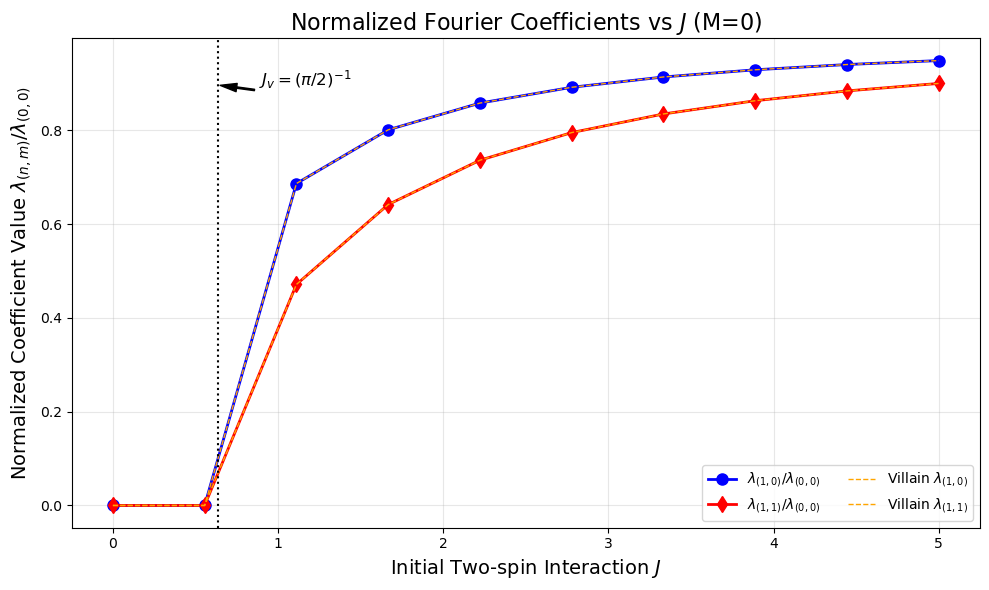

In [27]:
# Run analysis
J_values = np.linspace(0, 5.0, 10)
results = analyze_coefficients_vs_J_parallel(J_values, M=0, n_max=20, n_steps=10, b=3, d=2, n_workers=4)

# Plot all coefficients
plot_villain_comparison(results,
                        coeffs_to_show=['(1,0)', '(1,1)'],
                        figsize=(10, 6))
#plt.savefig("fixed-line_fixed-J.png", dpi=200)
plt.show()